In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [29]:
tg_api_token = '5102696637:AAHcm9cOmIF7-GyG7nHHJYA_yZCGSWSTu60'
tg_chat_id = '1126129331'

import requests

def send_tg_message(text='Cell execution completed.'):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=text)
    )

# Get Data

In [70]:
root_path = "WESAD"
zip_label = "_E4_Data.zip"
E4_label = "_E4_Data"

In [71]:
pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled"
}

In [10]:
def get_label(i):
    return pacient_state[i]

vec_get_label = np.vectorize(get_label)

In [9]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']

In [11]:
num_features = len(chest_signal_available)

In [12]:
# subjects_available = os.listdir(root_path)

# subjects_available

subjects_available = ['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']

subjects_available

['S5',
 'S2',
 'S3',
 'S4',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [13]:
try:
    subjects_available.remove(".DS_Store")
except:
    print(subjects_available)

print(subjects_available)

['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']
['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']


In [77]:
def get_input_chest_data(subjects_list):
    
    chest_df_list = []
    
    for subject in subjects_list:
        
        pkl_path = os.path.join(root_path, subject, subject + ".pkl")
        f=open(pkl_path,'rb')
        data=pickle.load(f,encoding='latin1')

        chest_data = {}

        for body_signal in chest_signal_available:
            if body_signal == "ACC_X":
                chest_data[body_signal] = data["signal"]["chest"]["ACC"][:,0]
            elif body_signal == "ACC_Y":
                chest_data[body_signal] = data["signal"]["chest"]["ACC"][:,1]
            elif body_signal == "ACC_Z":
                chest_data[body_signal] = data["signal"]["chest"]["ACC"][:,2]
            else:
                chest_data[body_signal]= data["signal"]["chest"][body_signal].reshape((len(data["label"])),)

        seven_indexes = np.where(data["label"] == 7)
        data["label"][seven_indexes] = 5
        six_indexes = np.where(data["label"] == 6)
        data["label"][six_indexes] = 5

        chest_data["label_id"] = data["label"]
        chest_data["label"] = vec_get_label(data["label"])
        chest_data["subject"] = data["subject"]

        chest_df_list.append(pd.DataFrame(chest_data))
        
    return chest_df_list

In [6]:
f=open("all_data",'rb')
data=pickle.load(f,encoding='latin1')

In [7]:
# input_chest_data = get_input_chest_data(subjects_available)
input_chest_data = data["input_data"]

In [80]:
len(input_chest_data)

15

In [13]:
# input_chest_data

# Investigating Data

In [81]:
sample_df = input_chest_data[-1]

sample_df.sample(20)

,ECG,EMG,EDA,Temp,Resp,label_id,label,subject
2927909,-0.029251,-0.000824,3.773880,34.091003,-1.701355,0,Not Defined/Transient,S15
2387586,0.012177,0.029251,3.409576,34.405579,5.335999,2,Stress,S15
1644990,0.026779,-0.007645,2.890396,33.963104,-3.556824,4,Meditation,S15
881514,-0.265411,-0.017990,2.128220,33.762573,-1.039124,1,Baseline,S15
458095,0.039963,0.067429,1.782608,33.756531,-0.424194,1,Baseline,S15
363261,-0.077499,0.011993,1.674271,33.689789,2.195740,1,Baseline,S15
2417154,-0.089859,0.000229,3.432083,34.448456,-2.079773,2,Stress,S15
2077482,0.098190,-0.005814,3.202057,34.119934,0.523376,0,Not Defined/Transient,S15
3469025,-0.024994,-0.002701,4.017639,34.274109,-2.406311,4,Meditation,S15
2387880,-0.097092,0.007095,3.425217,34.457642,0.120544,2,Stress,S15


In [82]:
sample_df["label_id"].value_counts()

0    1457401
1     822500
4     555799
2     480200
3     260400
5     100100
Name: label_id, dtype: int64

In [83]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676400 entries, 0 to 3676399
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   ECG       float64
 1   EMG       float64
 2   EDA       float64
 3   Temp      float32
 4   Resp      float64
 5   label_id  int32  
 6   label     object 
 7   subject   object 
dtypes: float32(1), float64(4), int32(1), object(2)
memory usage: 196.3+ MB


In [84]:
sample_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,3676400.0,0.001106,0.288565,-1.257111,-0.100937,-0.018265,0.020691,1.499496
EMG,3676400.0,-0.002721,0.018240,-0.379715,-0.010803,-0.002335,0.005081,0.500931
EDA,3676400.0,2.909373,0.837835,1.250076,2.148819,3.001404,3.648758,4.318237
Temp,3676400.0,33.014595,1.119261,33.010864,33.815674,34.054443,34.407104,34.907837
Resp,3676400.0,0.055039,4.501873,-22.190857,-2.311707,-0.172424,2.561951,28.750610
label_id,3676400.0,1.438308,1.553870,0.000000,0.000000,1.000000,2.000000,5.000000


In [19]:
sample_df["label_id"].unique()

array([0, 1, 5, 3, 4, 2], dtype=int32)

In [20]:
unique_values, counts = np.unique(sample_df["label_id"], axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [1472098  830200  448000  260401  553001  102900]
[0 1 2 3 4 5] [0.40148857 0.2264223  0.12218404 0.07101975 0.1508212  0.02806415]


In [2]:
def plot_signal_label(df, sample_rate=700):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)
    # df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ACC_X", "label_id"], ax=ax6)
    # df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ACC_Y", "label_id"], ax=ax7)
    # df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ACC_Z", "label_id"], ax=ax8)

In [22]:
def plot_corr(df, correlation_type="pearson"):

    corr_df  = df.corr(correlation_type)

    fig, ax_corr = plt.subplots(1, 1, figsize=(50,20))
    sns.heatmap(corr_df, annot=True, ax=ax_corr)


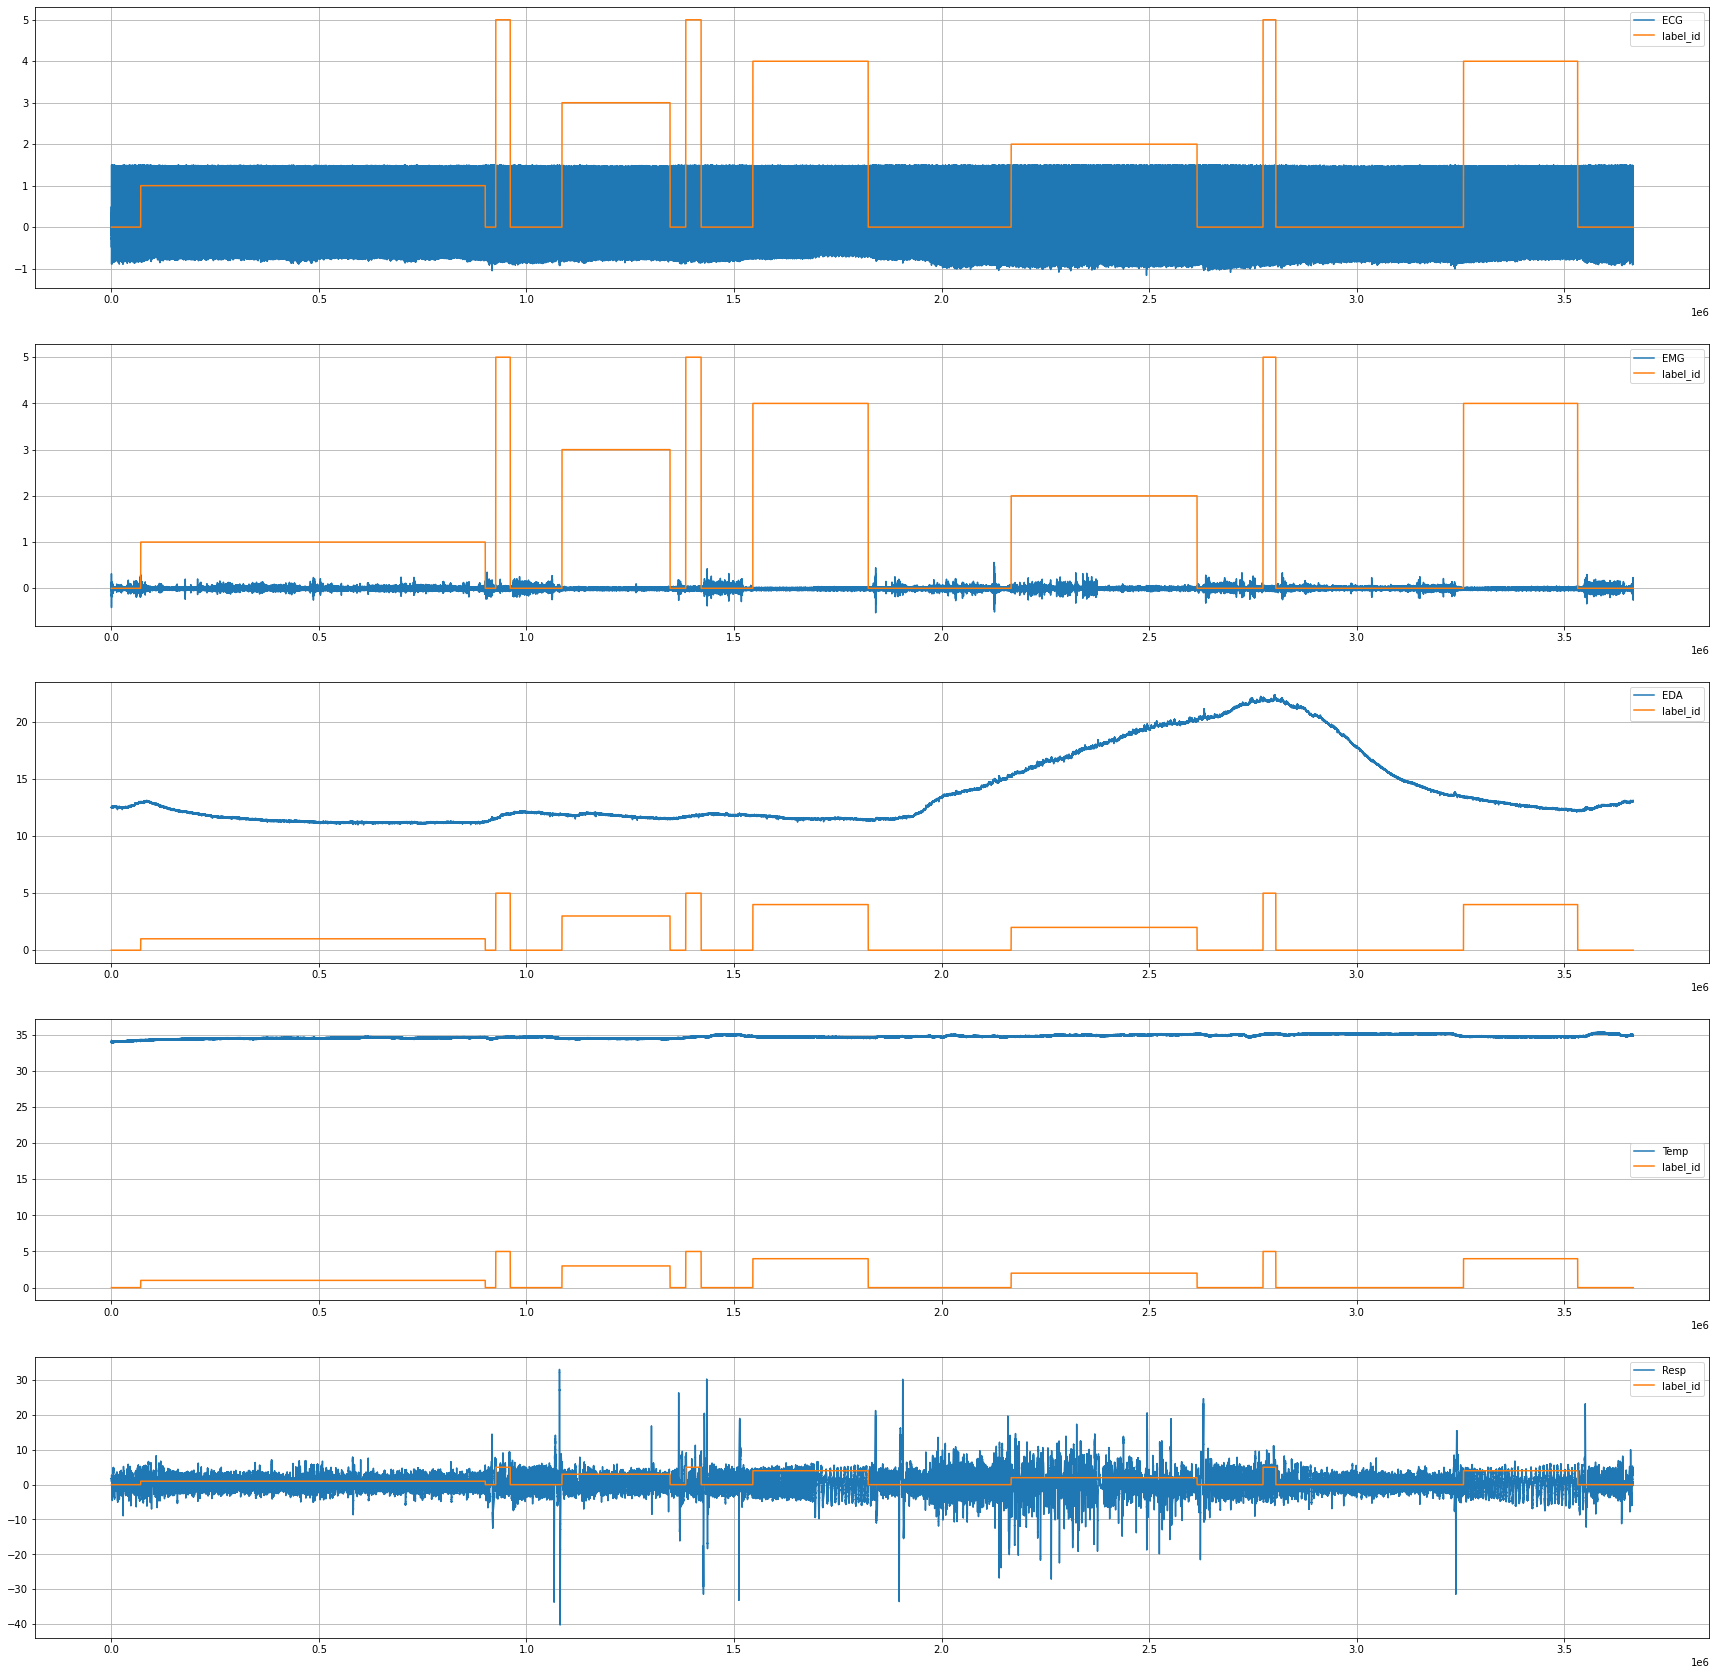

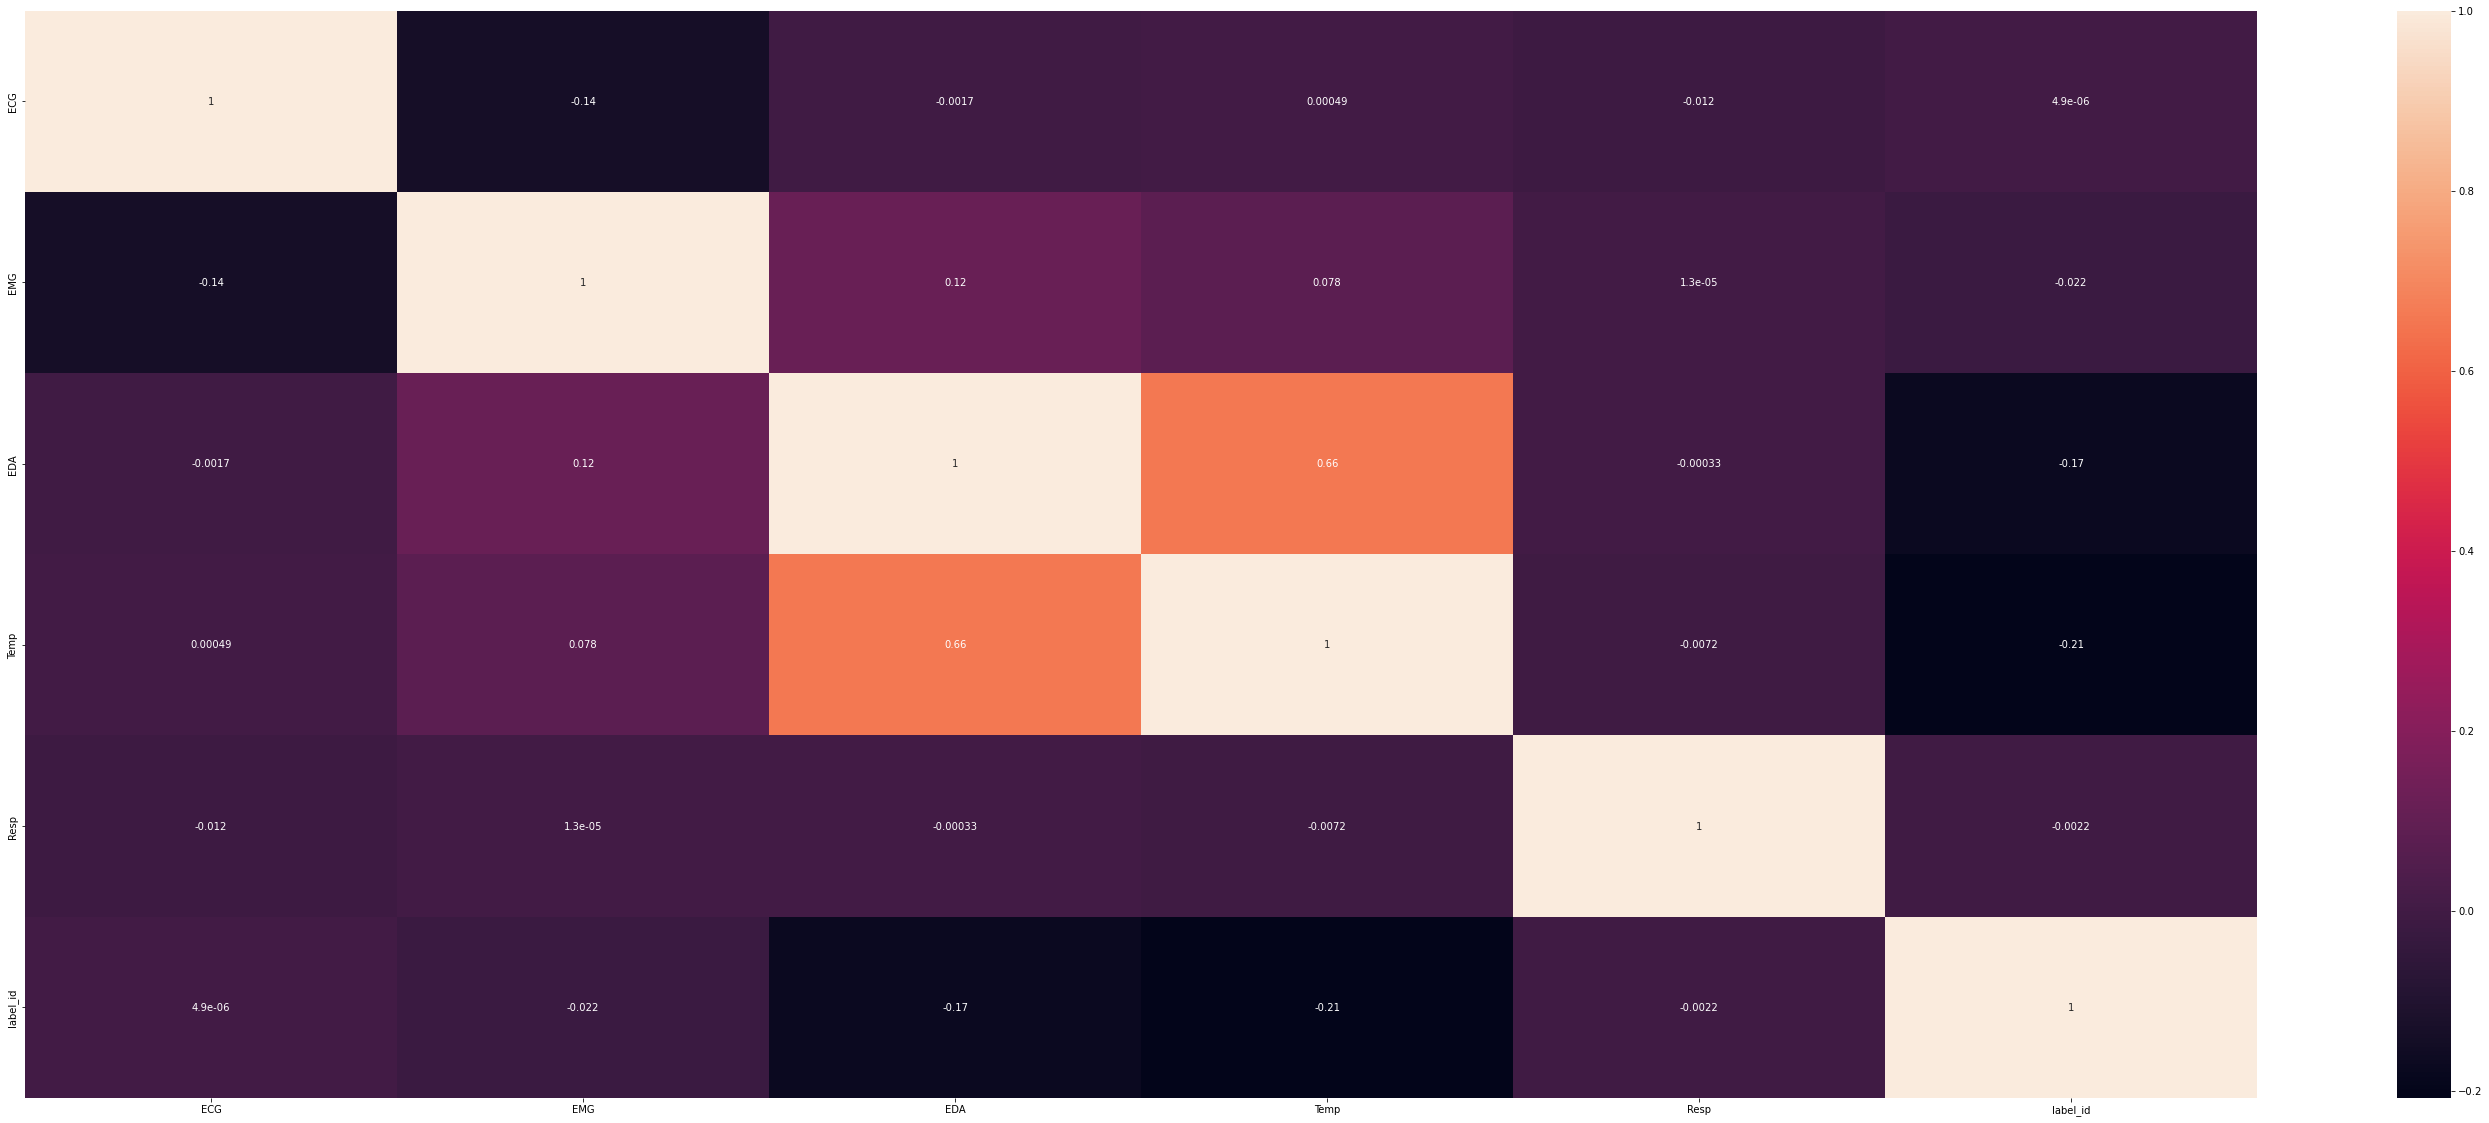

In [23]:
plot_signal_label(sample_df, None)
plot_corr(sample_df)

## Analysis of Win Size and Resample

In [ ]:
def separate_signal(df, signal_label):
    label_index = df[df["label_id"] == signal_label].index
    label_df = df.iloc[label_index].reset_index(drop=True)
    return label_df

def get_data_labels_to_classify(df):
    return separate_signal(df, 1), separate_signal(df, 2), separate_signal(df, 3)

In [ ]:
baseline_df, stress_df, amusement_df = get_data_labels_to_classify(sample_df)

In [ ]:
# To each label plot:
# 1) 1 sec window whitheout resampling 
# 2) 60 sec window whitheout resampling
# 3) 60 sec window whith resampling

plt.rcParams.update({'font.size': 12})

fig_global, ax_global = plt.subplots(5,9)

In [ ]:
def plot_win_size_analysis(df, sample_rate=700, index_begin=None, index_end=None, figs_posistion_column = 0, colum_fig_title = ""):

    plot_df = df.iloc[index_begin:index_end:sample_rate]

    plot_df.plot(figsize=(60, 40), grid=True, y=["ECG", "label_id"], ax=ax_global[0][figs_posistion_column])
    plot_df.plot(figsize=(60, 40), grid=True, y=["EMG", "label_id"], ax=ax_global[1][figs_posistion_column])
    plot_df.plot(figsize=(60, 40), grid=True, y=["EDA", "label_id"], ax=ax_global[2][figs_posistion_column])
    plot_df.plot(figsize=(60, 40), grid=True, y=["Temp", "label_id"], ax=ax_global[3][figs_posistion_column])
    plot_df.plot(figsize=(60, 40), grid=True, y=["Resp", "label_id"], ax=ax_global[4][figs_posistion_column])

    ax_global[0][figs_posistion_column].set_title(colum_fig_title)

In [ ]:
baseline_oneSec_noResampling = plot_win_size_analysis(baseline_df, sample_rate = 1, index_begin = 0, index_end = 700, figs_posistion_column = 0, colum_fig_title = "Baseline Signal - 1 Second with No Resampling")
baseline_sixtySec_noResampling = plot_win_size_analysis(baseline_df, sample_rate = 1, index_begin = 0, index_end = 42000, figs_posistion_column = 1, colum_fig_title = "Baseline Signal - 60 Seconds with No Resampling")
baseline_sixtySec_Resampling = plot_win_size_analysis(baseline_df, sample_rate = 700, index_begin = 0, index_end = 42000, figs_posistion_column = 2, colum_fig_title = "Baseline Signal - 60 Seconds with Resampling")

stress_oneSec_noResampling = plot_win_size_analysis(stress_df, sample_rate = 1, index_begin = 0, index_end = 700, figs_posistion_column = 3, colum_fig_title = "Stress Signal - 1 Second with No Resampling")
stress_sixtySec_noResampling = plot_win_size_analysis(stress_df, sample_rate = 1, index_begin = 0, index_end = 42000, figs_posistion_column = 4, colum_fig_title = "Stress Signal - 60 Seconds with No Resampling")
stress_sixtySec_Resampling = plot_win_size_analysis(stress_df, sample_rate = 700, index_begin = 0, index_end = 42000, figs_posistion_column = 5, colum_fig_title = "Stress Signal - 60 Seconds with Resampling")

amusement_oneSec_noResampling = plot_win_size_analysis(amusement_df, sample_rate = 1, index_begin = 0, index_end = 700, figs_posistion_column = 6, colum_fig_title = "Amusement Signal - 1 Second with No Resampling")
amusement_sixtySec_noResampling = plot_win_size_analysis(amusement_df, sample_rate = 1, index_begin = 0, index_end = 42000, figs_posistion_column = 7, colum_fig_title = "Amusement Signal - 60 Seconds with No Resampling")
amusement_sixtySec_Resampling = plot_win_size_analysis(amusement_df, sample_rate = 700, index_begin = 0, index_end = 42000, figs_posistion_column = 8, colum_fig_title = "Amusement Signal - 60 Seconds with Resampling")

In [ ]:
fig_global.get_figure()

## Removing unecessary labels

In [ ]:
indexes_to_drop = sample_df[(sample_df["label_id"] == 0) | (sample_df["label_id"] == 4) | (sample_df["label_id"] == 5)].index

In [ ]:
cleaned_sample_df = sample_df.drop(indexes_to_drop)

In [11]:
cleaned_sample_df.sample(20)

NameError: name 'cleaned_sample_df' is not defined

In [ ]:
cleaned_sample_df = cleaned_sample_df.reset_index(drop=True)

In [ ]:
cleaned_sample_df.head()

In [ ]:
cleaned_sample_df["label_id"] = cleaned_sample_df["label_id"] - 1

In [ ]:
cleaned_sample_df.info()

In [ ]:
cleaned_sample_df.describe().T

In [ ]:
plot_signal_label(cleaned_sample_df, None)
plot_corr(cleaned_sample_df)

In [ ]:
def adjust_remove_labels(df, labels_to_remove):

    df_copy = df.copy()
    indexes_to_remove = df_copy[(df_copy["label_id"] == labels_to_remove[0]) | (df_copy["label_id"] == labels_to_remove[1]) | (df_copy["label_id"] == labels_to_remove[2])].index
    df_copy = df_copy.drop(indexes_to_remove)

    df_copy = df_copy.reset_index(drop=True)

    df_copy["label_id"] = df_copy["label_id"] - 1

    return df_copy

In [ ]:
clean_input_chest_data = []

for data in input_chest_data:
    clean_input_chest_data.append(adjust_remove_labels(data, [0, 4, 5]))

In [ ]:
clean_input_chest_data[-1].sample(10)

In [ ]:
plot_signal_label(clean_input_chest_data[-1])
plot_corr(clean_input_chest_data[-1])

## Oversample Data Analysis

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
oversample = SMOTE()

In [ ]:
sample_df[chest_signal_available][::700]

In [ ]:
X, y = oversample.fit_resample(sample_df[chest_signal_available][::700], sample_df["label_id"][::700])

In [ ]:
X

In [ ]:
y.value_counts()

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))

ax1.plot(X["EDA"])
ax1.plot(y)
ax1.grid(True)

## Fourier Analsys

In [12]:
# from numpy.fft import fft, ifft, fftfreq
# from scipy import pi, signal, fftpack
# def annot_max(x, y, ax=None):
#     xmax = x[np.argmax(y)]
#     ymax = y.max()
#     text= "x={:.3f}, y={:.3f}".format(xmax, ymax) 
#     #text = f"{xmax=}, {ymax=}, (period: {1./xmax} days)" #Eh, Colab has Python 3.6 ... 
#     text = f"x={xmax:.3f}, y={ymax:.3f}, (period: {(1./xmax):.2f} )"
#     if not ax:
#         ax=plt.gca()
#     bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
#     arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
#     kw = dict(xycoords='data',textcoords="axes fraction",
#               arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
#     ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)
# def plot_fft(signal, signal_name="", f_rate = 700*7/10):
#     plt.rcdefaults()

#     nobs = len(signal)
#     signal_ft = np.abs(fft(signal))
#     signal_freq = fftfreq(nobs, 1/f_rate)

#     plt.figure(figsize=(20,2))
#     plt.plot(signal_freq[2:], signal_ft[2: ])
#     annot_max(signal_freq[2:], signal_ft[2: ])
#     plt.grid()

#     plt.ylabel(f"{signal_name}")
#     plt.xlabel('frequency')
#     plt.show()
# for signal in sample_df.columns:
#     if (signal != "label_id" and signal != "label" and signal != "subject"):
#         plot_fft(sample_df[signal], signal)
# for signal in sample_df.columns:
#     if (signal != "label_id" and signal != "label" and signal != "subject"):
#         plot_fft(sample_df[signal][::700], signal)
# for signal in sample_df.columns:
#     if (signal != "label_id" and signal != "label" and signal != "subject"):
#         plot_fft(sample_df[signal][::700][:60], signal)
# def plot_fft(signal, signal_name="", f_rate = 700*7/10):
#     plt.rcdefaults()

#     nobs = len(signal)
#     signal_ft = np.abs(fft(signal))
#     signal_freq = fftfreq(nobs, 1/f_rate)

#     plt.figure(figsize=(20,2))
#     plt.plot(signal_freq[2:], signal_ft[2: ])
#     annot_max(signal_freq[2:], signal_ft[2: ])
#     plt.grid()

#     plt.ylabel(f"{signal_name}")
#     plt.xlabel('frequency')
#     plt.show()
# def low_pass(s, threshold=2e4, f_rate = 700*7/10):
#     fourier = fft(s)
#     frequencies = fftfreq(s.size, f_rate)
#     fourier[frequencies > threshold] = 0
#     signal_ft = np.abs(fourier)

#     plt.figure(figsize=(20,2))
#     plt.plot(frequencies[2:], signal_ft[2: ])
#     annot_max(frequencies[2:], signal_ft[2: ])
#     plt.grid()
#     plt.show()

#     return np.real_if_close(ifft(fourier))
# plot_fft(sample_df["ECG"], "ECG")
# teste = low_pass(sample_df["ECG"], 6)
# teste
# plot_fft(low_pass(sample_df["ECG"], threshold = 6), "ECG")
# plot_fft(sample_df["ECG"], "ECG")
# fig = plt.figure(figsize=(40,14))
# plt.xlabel('time',fontsize=40, labelpad=25)
# plt.ylabel('EMG',fontsize=40, labelpad=25)
# plt.plot(sample_df["ECG"], linewidth=1)
# plt.plot(teste, linewidth=5)
# plt.legend(['Real value','FFT smoothing'], prop={'size': 20})
# plt.title('',fontsize=40, pad=30)

# plt.show()

# Cleaning Data

In [2]:
# win_size = 60 # will represent 1 minute
# win_size = 5*700 # will represent 5 seconds
# step_slinding_window = 700//4 # moving the window in 0.25 sec
win_size = (60*700)//100
step_slinding_window = 1 

# win_size = 630

def simple_rolling_z_score(x, win_size):
    r = x.rolling(window=win_size)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [4]:
def rolling_z_score(df, win_size, step_slinding_window = 1):

    copy_df = df.copy()

    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i, step_slinding_window)
        mean = df[slicer].mean()
        std = df[slicer].std(ddof=0)
        
        print(f"Normalazing Window {i}", end="\r", flush=True)

        copy_df[slicer] = (df[slicer] - mean) / std

    return copy_df


In [14]:
clean_chest_data = []

print(f"Window Size: {win_size}, and Step: {step_slinding_window}\n\n")

for data_df in input_chest_data:

    # Resampling data choosing one point each 700 points
    resample_data_df = data_df[::100]

    # Separating features and targets
    X, y = resample_data_df[chest_signal_available], resample_data_df["label_id"]

    # Getting subject label
    subject_label = resample_data_df.pop("subject").to_numpy()[0]

    # Oversampling data
    # X, y = oversample.fit_resample(X, y)

    # Convert target to numpy
    target = y.to_numpy()

    print(f"Start Normalization of Subject {subject_label}\n\n", end="\r", flush=True)

    # applying rolling score-z
    feature_df = rolling_z_score( X, win_size)

    print(f"\n\nEnd of Normalization of Subject {subject_label}", end="\r", flush=True)

    clean_chest_data.append((feature_df, target, subject_label))

del input_chest_data
gc.collect()

Window Size: 420, and Step: 1


Start Normalization of Subject S5

Normalazing Window 43386

Start Normalization of Subject S25

Normalazing Window 42133

Start Normalization of Subject S32

Normalazing Window 45031

Start Normalization of Subject S43



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Normalazing Window 36141

Start Normalization of Subject S13



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
with open("cleaned_data", 'wb') as f:
    pickle.dump({
        "cleaned_data": clean_chest_data
    }, f)

In [22]:
print("FINISHED")

FINISHED


In [23]:
f=open("cleaned_data",'rb')
data=pickle.load(f,encoding='latin1')
# input_chest_data = get_input_chest_data(subjects_available)
clean_chest_data = data["cleaned_data"]

In [24]:
len(clean_chest_data), len(clean_chest_data[-1])

(15, 3)

In [25]:
clean_chest_data[-1][0].describe().T

,count,mean,std,min,25%,50%,75%,max
ECG,36764.0,0.000572,1.001112,-2.745188,-0.357551,-0.065496,0.084416,7.126577
EMG,36764.0,-0.001170,1.033486,-8.452148,-0.498697,0.018170,0.510520,15.990608
EDA,36764.0,-0.879058,1.094445,-15.859101,-1.547475,-1.038559,-0.443374,9.965831
Temp,36764.0,-0.246227,1.220402,-6.271583,-1.010028,-0.222978,0.559405,7.536195
Resp,36764.0,-0.003164,1.065264,-5.589568,-0.593456,-0.059144,0.627566,6.638109


In [26]:
validation_plot_df = pd.concat([clean_chest_data[-1][0].reset_index(), pd.DataFrame(clean_chest_data[-1][1], columns=["label_id"])], axis=1, join="inner")

In [27]:
validation_plot_df

,index,ECG,EMG,EDA,Temp,Resp,label_id
0,0,-0.073030,-0.989212,-0.553428,-0.612381,0.172338,0
1,100,0.183725,-0.017348,1.439158,-0.888119,0.040623,0
2,200,-0.181273,-2.037852,-1.068578,-1.072697,0.064512,0
3,300,-0.902624,-1.500286,-1.365398,-1.849779,0.207328,0
4,400,-1.000099,0.532425,-1.713094,-0.814436,0.300228,0
...,...,...,...,...,...,...,...
36759,3675900,-1.070759,-0.210678,0.101853,-0.659474,1.370529,0
36760,3676000,-0.511652,0.126479,0.092461,-1.121810,1.003749,0
36761,3676100,0.029973,0.905265,0.205159,-0.381704,0.651758,0
36762,3676200,0.068003,-0.407749,0.073678,-0.427845,0.312136,0


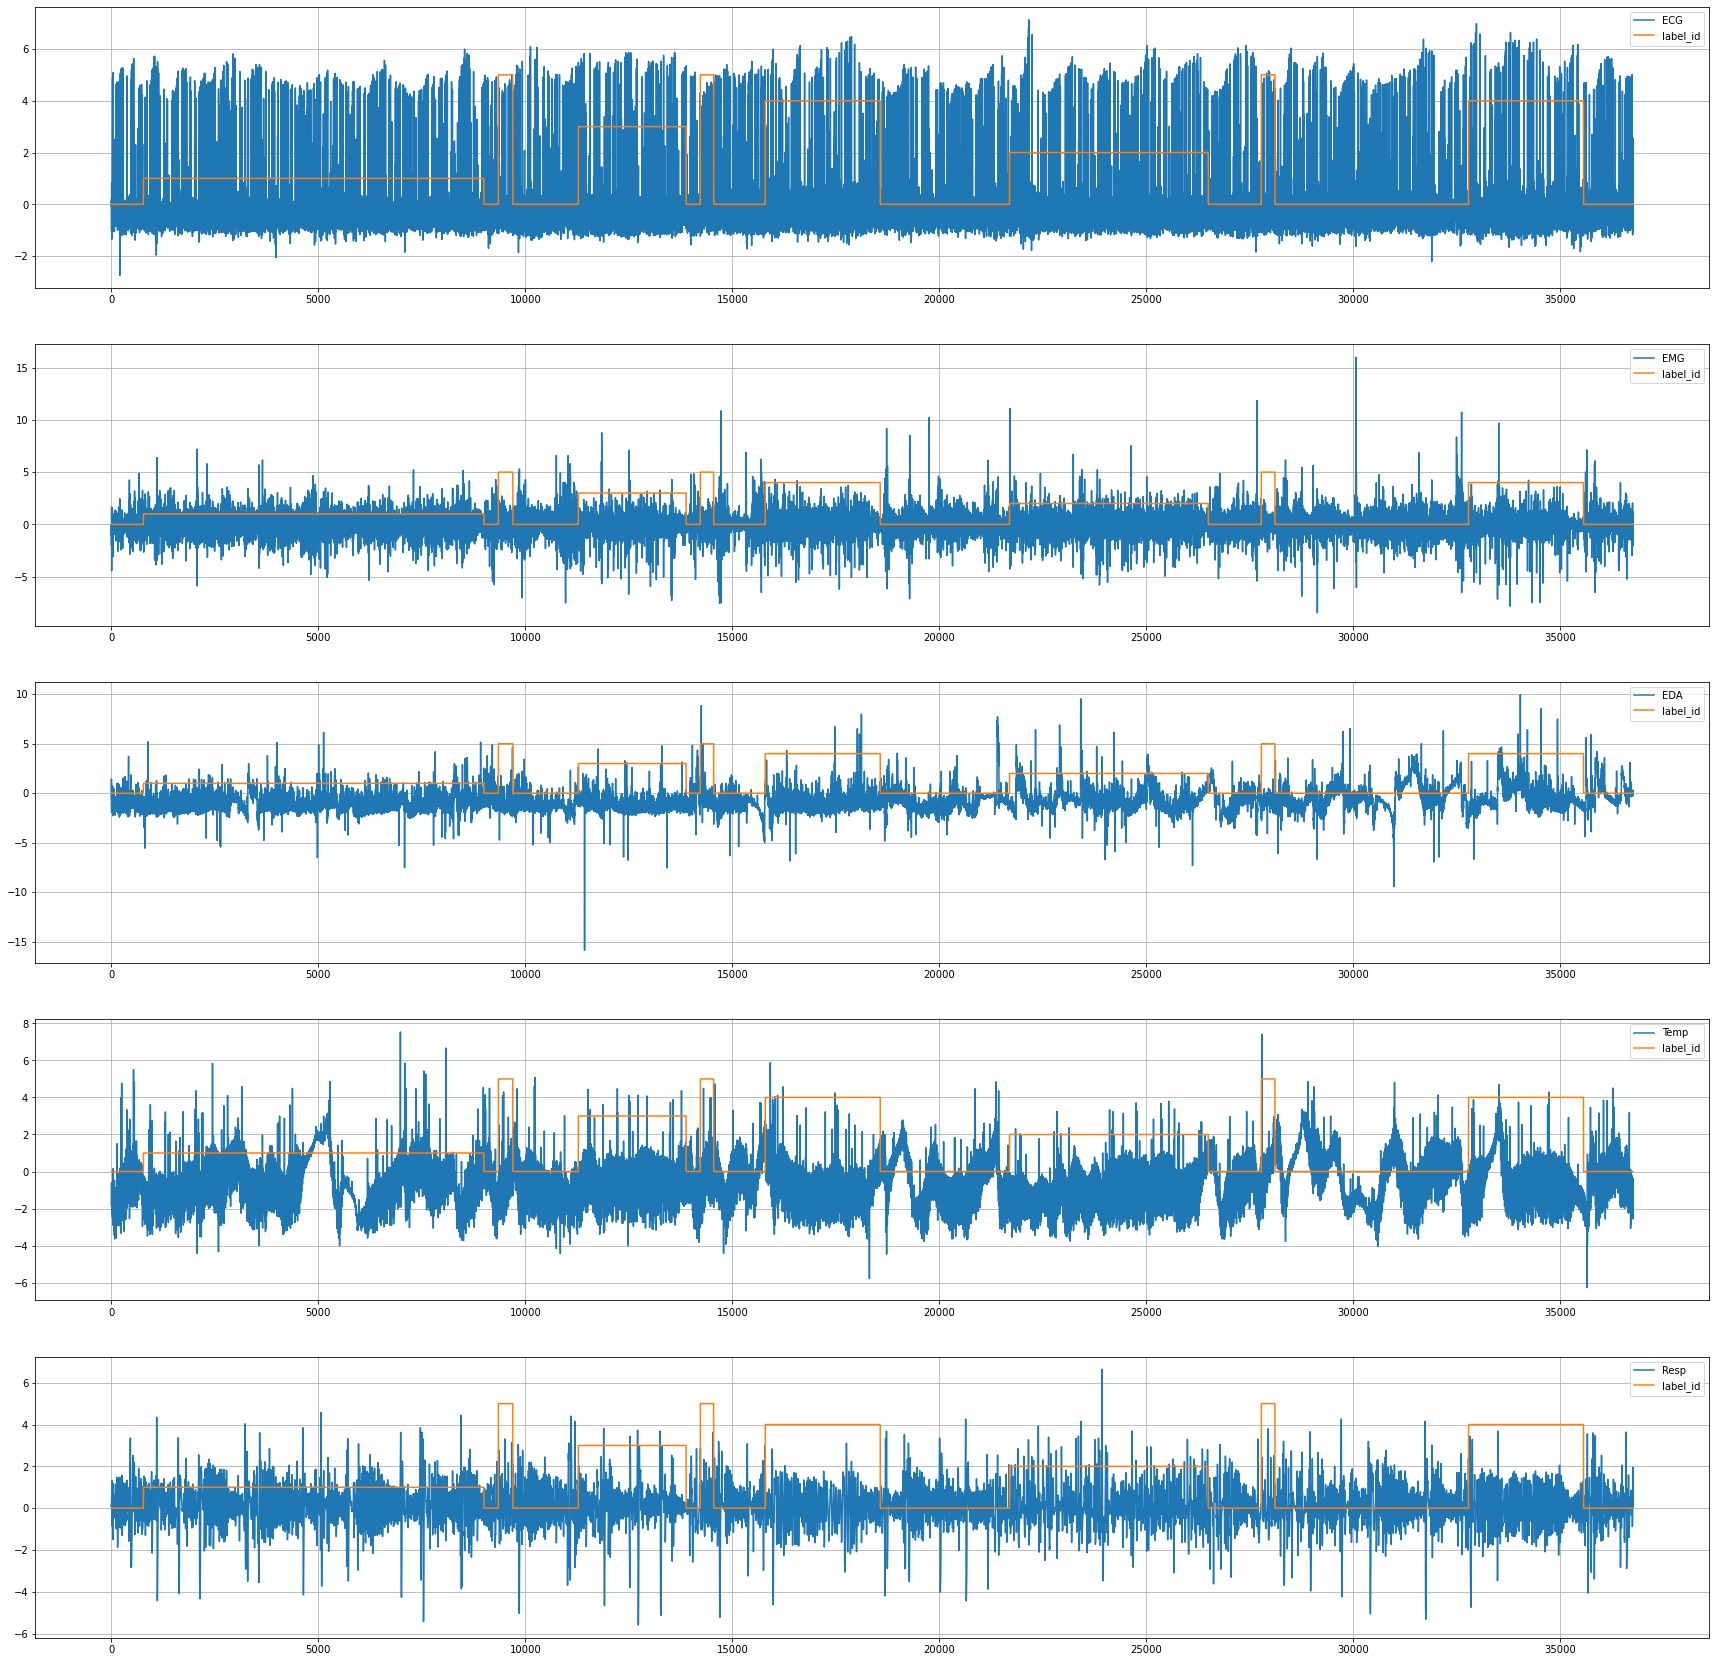

In [28]:
plot_signal_label(validation_plot_df, None)

In [30]:
clean_chest_data[-1][1].shape, clean_chest_data[-1][2]

((36764,), 'S15')

In [31]:
unique_values, counts = np.unique(clean_chest_data[-1][1], axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [14574  8225  4802  2604  5558  1001]
[0 1 2 3 4 5] [0.39642041 0.2237243  0.13061691 0.07083016 0.1511805  0.02722772]


In [26]:
# unique_values, counts = np.unique(cleaned_sample_df["label_id"], axis=0, return_counts=True)
# print(f"{unique_values} {counts}")
# print(f"{unique_values} {counts/sum(counts)}")

# Windowing

In [41]:
# def get_windows(arr, win_size, win_slide):
#     I = np.expand_dims(np.arange(win_size), 0) + np.expand_dims(np.arange(len(arr) - win_size + 1, step=win_slide), 0).T
#     return arr[I]

# def get_most_repeted_element(np_array):
#     (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
#     most_repeted_element_index = np.where(counts == max(counts))
#     percentage_of_elements = counts/sum(counts)
#     return unique[most_repeted_element_index[0][0]] , percentage_of_elements[most_repeted_element_index[0][0]]

# def get_window_label_labelFreq(np_array, win_size = 60, step_slinding_window = 1):
#     windows_features = get_windows(arr = np_array, win_size = win_size, win_slide = step_slinding_window)
#     del np_array
#     gc.collect()
#     return np.array([get_most_repeted_element(arr) for arr in windows_features])

# def get_windows_features(np_array, win_size = 60, step_slinding_window = 1):
#     windows_features = get_windows(arr = np_array, win_size = win_size, win_slide = step_slinding_window)
#     del np_array
#     gc.collect()
#     return windows_features

# def remove_transition_windows(features, targets_targetsFreq, freq_threshold=0.55):
#     indexes = np.where(targets_targetsFreq[:,1] < freq_threshold)
#     clean_features = np.delete(features, indexes, axis=0)
#     clean_targets = np.delete(targets_targetsFreq[:, 0], indexes)
#     del features
#     del targets_targetsFreq
#     gc.collect()
#     return clean_features, clean_targets

win_size = (60*700)//100
step_slinding_window = 1


def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    percentage_of_elements = counts/sum(counts)
    return unique[most_repeted_element_index[0][0]] , percentage_of_elements[most_repeted_element_index[0][0]]

def remove_data(features, targets, label_id):
    indexes = np.where(targets == label_id)
    return np.delete(features, indexes, axis=0), np.delete(targets, indexes)

def update_labels(targets, old_label_id, new_label_id):
    '''baseline = 0, stress = 1, amusement = 2'''
    indexes = np.where(targets == old_label_id)
    targets[indexes] = new_label_id
    return targets

def get_features_and_targets(features_np_array, targets_np_array, win_size = 60, step_slinding_window = 1, freq_threshold=0.60, verbose=False):
    
    features = []
    targets = []
    elemets_debug = []
    
#     for label_id in [0, 4, 5]:
#         features_aux, targets_aux = remove_data(features_np_array, targets_np_array, label_id)

    features_aux, targets_aux = features_np_array, targets_np_array


#     for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
#         targets_aux = update_labels(targets_aux, old_label_id, new_label_id)

    
    for i in range(len(targets_np_array) - win_size + 1):
        
        print(f"Window {i}", end="\r", flush=True)
        
        slicer = slice(i, win_size + i)
        
        feature_window = features_aux[slicer]
        target_window = targets_aux[slicer]
        
        element, element_freq = get_most_repeted_element(target_window)
        elemets_debug.append((element, element_freq))
        
        if element_freq >= freq_threshold:
            features.append(feature_window)
            targets.append(element)
    
    return np.array(features), np.array(targets), elemets_debug
            

In [42]:
unique_values, counts = np.unique(clean_chest_data[0][1], axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [21427  8386  4515  2618  5558  1302]
[0 1 2 3 4 5] [0.48913391 0.19143496 0.10306807 0.0597635  0.1268776  0.02972196]


In [48]:
def remove_data(features, targets, label_id):
    indexes = np.where(targets == label_id)
    return np.delete(features, indexes, axis=0), np.delete(targets, indexes)

def update_labels(targets, old_label_id, new_label_id):
    '''baseline = 0, stress = 1, amusement = 2'''
    indexes = np.where(targets == old_label_id)
    targets[indexes] = new_label_id
    return targets

In [ ]:
for label_id in [0, 4, 5]:
    features, targets = remove_data(features, targets, label_id)
print(features.shape, targets.shape)

for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    targets = update_labels(targets, old_label_id, new_label_id)
print(features.shape, targets.shape)

In [43]:
features_test, targets_test, elements_debug = get_features_and_targets(clean_chest_data[0][0].to_numpy(), clean_chest_data[0][1], win_size=win_size, step_slinding_window=step_slinding_window)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [44]:
send_tg_message("Terminou de gerar as janelas")

In [46]:
features_test.shape, targets_test.shape

((42059, 420, 5), (42059,))

In [45]:
unique_values, counts = np.unique(targets_test, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [20344  8303  4432  2535  5392  1053]
[0 1 2 3 4 5] [0.48370147 0.19741316 0.10537578 0.06027247 0.12820086 0.02503626]


In [47]:
validation_data = clean_chest_data.pop()

In [48]:
validation_data[2]

'S15'

In [49]:
unique_values, counts = np.unique(validation_data[1], axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [14574  8225  4802  2604  5558  1001]
[0 1 2 3 4 5] [0.39642041 0.2237243  0.13061691 0.07083016 0.1511805  0.02722772]


In [50]:
validation_features, validation_targets, _ = get_features_and_targets(validation_data[0].to_numpy(), validation_data[1], win_size=win_size, step_slinding_window=step_slinding_window)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Window 13414

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Window 32867

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [51]:
send_tg_message("Terminou de gerar as janelas da validação")

In [52]:
validation_features.shape, validation_targets.shape

((35017, 420, 5), (35017,))

In [53]:
unique_values, counts = np.unique(validation_targets, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0 1 2 3 4 5] [13491  8142  4719  2521  5392   752]
[0 1 2 3 4 5] [0.38527001 0.23251564 0.13476312 0.0719936  0.15398235 0.02147528]


In [ ]:
features = []
targets = []
i = 0

for data in clean_chest_data:
    
    print(f"\n\nJoinning Window of Subject {data[2]}\n\n")
    send_tg_message(f"Joinning Window of Subject {data[2]}, we have {len(clean_chest_data) - i} to go.")
    i = i + 1

    subject_features, subject_targets, _ = get_features_and_targets(data[0].to_numpy(), data[1], win_size=win_size, step_slinding_window=step_slinding_window)
    features.append(subject_features)
    targets.append(subject_targets)

    del subject_features
    del subject_targets
    del data

    gc.collect()

del clean_chest_data
gc.collect()

features = np.array(features)
targets = np.array(targets)

send_tg_message("Terminou carai!")



Joinning Window of Subject S5




IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Window 43386

Joinning Window of Subject S2




IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Window 42133

Joinning Window of Subject S3




IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Window 13771

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)





Joinning Window of Subject S10




IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# features_raw = np.concatenate(tuple(get_windows_features(data[0].to_numpy(), win_size=win_size, step_slinding_window=step_slinding_window) for data in clean_chest_data), axis=0)
# targets_targetsFreq_raw = np.concatenate(tuple(get_window_label_labelFreq(data[1], win_size=win_size, step_slinding_window=step_slinding_window) for data in clean_chest_data), axis=0)
# features, targets = remove_transition_windows(features_raw, targets_targetsFreq_raw)

In [ ]:
features.shape, targets.shape

# Model

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Activation, GRU, GaussianNoise, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import convert_to_tensor

import datetime

## Adjusting data for the model

To compare with wesade article, the model will classify only Baseline x Stress x Amusement

In [ ]:
def remove_data(features, targets, label_id):
    indexes = np.where(targets == label_id)
    return np.delete(features, indexes, axis=0), np.delete(targets, indexes)

def update_labels(targets, old_label_id, new_label_id):
    '''baseline = 0, stress = 1, amusement = 2'''
    indexes = np.where(targets == old_label_id)
    targets[indexes] = new_label_id
    return targets

In [ ]:
for label_id in [0, 4, 5]:
    features, targets = remove_data(features, targets, label_id)
print(features.shape, targets.shape)

for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    targets = update_labels(targets, old_label_id, new_label_id)
print(features.shape, targets.shape)

In [42]:
unique_values, counts = np.unique(targets, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[1. 2. 3.] [114071  64078  35539]
[1. 2. 3.] [0.53382034 0.2998671  0.16631257]


In [43]:
for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    targets = update_labels(targets, old_label_id, new_label_id)
features.shape, targets.shape

((213688, 630, 5), (213688,))

In [44]:
unique_values, counts = np.unique(targets, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0. 1. 2.] [114071  64078  35539]
[0. 1. 2.] [0.53382034 0.2998671  0.16631257]


In [45]:
validation_features.shape, validation_targets.shape

((34322, 630, 5), (34322,))

In [46]:
for label_id in [0, 4, 5]:
    validation_features, validation_targets = remove_data(validation_features, validation_targets, label_id)
validation_features.shape, validation_targets.shape

((15442, 630, 5), (15442,))

In [47]:
for old_label_id, new_label_id in [(1, 0), (2, 1), (3, 2)]:
    validation_targets = update_labels(validation_targets, old_label_id, new_label_id)
validation_features.shape, validation_targets.shape

((15442, 630, 5), (15442,))

In [48]:
unique_values, counts = np.unique(targets, axis=0, return_counts=True)
print(f"{unique_values} {counts}")
print(f"{unique_values} {counts/sum(counts)}")

[0. 1. 2.] [114071  64078  35539]
[0. 1. 2.] [0.53382034 0.2998671  0.16631257]


In [49]:
num_classes = len(unique_values)

In [50]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(targets), y = targets)
weights = {i : weights[i] for i in range(len(weights))}
weights

{0: 0.6244298141800575, 1: 1.1116035664866777, 2: 2.0042582327396192}

In [51]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, stratify=targets)

In [52]:
x_train.shape, x_test.shape

((128212, 630, 5), (85476, 630, 5))

In [53]:
y_train.shape, y_test.shape

((128212,), (85476,))

In [54]:
x_train_tensor = convert_to_tensor(x_train)
x_test_tensor = convert_to_tensor(x_test)
y_train_tensor = convert_to_tensor(y_train, dtype="int64")
y_test_tensor = convert_to_tensor(y_test, dtype="int64")

2022-01-10 09:57:39.276084: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-10 09:57:39.596740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:41:00.0, compute capability: 7.5
2022-01-10 09:57:39.597880: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3230942400 exceeds 10% of free system memory.
2022-01-10 09:57:40.825885: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2153995200 exceeds 10% of free system memory.


In [55]:
x_train_tensor.shape, x_test_tensor.shape

(TensorShape([128212, 630, 5]), TensorShape([85476, 630, 5]))

In [56]:
y_train_tensor.shape, y_test_tensor.shape

(TensorShape([128212]), TensorShape([85476]))

## Model

In [57]:
num_classes, num_features

(3, 5)

In [58]:
def lstm(model = None):
    model.add(LSTM(128, input_shape=(win_size, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(GaussianNoise(0.5))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(num_classes, activity_regularizer = L2(0.000001), bias_constraint = max_norm(3)))

def gru(model = None):
    model.add(GRU(128, input_shape=(win_size, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(GaussianNoise(0.5))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(num_classes, activity_regularizer = L2(0.000001), bias_constraint = max_norm(3)))


In [59]:
# duas lstm uma dropout e uma dense
# testar uma GRU (trocar todas as LSTM por elas)


def create_model(has_activator, last_activation_layer, hidden_layer_type, optimizer):

    model = Sequential()
    hidden_layer_type(model)
    if has_activator:
        model.add(Activation(last_activation_layer))
    model.build()

    model.summary()

    model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = optimizer, #nadam or rmstrop
        metrics = ["sparse_categorical_accuracy", "accuracy"]
    )

    return model


In [60]:
models_to_test = {
    "softmax_lstm_adam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "blue",
        "layers": lstm,
        "optimizer": "adam",
        "callbacks": [
            EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/lstm/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_lstm_nadam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "red",
        "layers": lstm,
        "optimizer": "nadam",
        "callbacks": [
            EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/lstm/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_lstm_rmsprop": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "green",
        "layers": lstm,
        "optimizer": "rmsprop",
        "callbacks": [
            EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/lstm/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_adam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "yellow",
        "layers": gru,
        "optimizer": "adam",
        "callbacks": [
            EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_nadam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "magenta",
        "layers": gru,
        "optimizer": "nadam",
        "callbacks": [
            EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_rmsprop": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "cyan",
        "layers": gru,
        "optimizer": "rmsprop",
        "callbacks": [
            EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    }   
}

In [ ]:
for model_name in models_to_test:

    has_activator = models_to_test[model_name]["has_activator"]
    activation_layer = models_to_test[model_name]["activator_layer"]
    hidden_layer = models_to_test[model_name]["layers"]
    optimizer = models_to_test[model_name]["optimizer"]

    model = create_model(has_activator, activation_layer, hidden_layer, optimizer)
    history = model.fit(
        x=x_train_tensor,
        y=y_train_tensor,
        validation_data=(x_test_tensor, y_test_tensor),
        epochs=100,
        shuffle=False,
        class_weight=weights,
        callbacks=models_to_test[model_name]["callbacks"]
    )

    # model.save(f"models/stress_detection_{model_name}")

    models_to_test[model_name]["history"] = history
    models_to_test[model_name]["model"] = model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 630, 128)          68608     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 630, 128)          0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 630, 128)         0         
 se)                                                             
                                                                 
 dropout (Dropout)           (None, 630, 128)          0         
                                                                 
 flatten (Flatten)           (None, 80640)             0         
                                                                 
 dense (Dense)               (None, 3)                 241923    
                                                        

2022-01-10 09:57:41.794604: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3230942400 exceeds 10% of free system memory.


Epoch 1/100


2022-01-10 09:57:43.884161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


4007/4007 [==============================] - ETA: 0s - loss: 1.5201 - sparse_categorical_accuracy: 0.8061 - accuracy: 0.8061

2022-01-10 09:59:31.473848: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2153995200 exceeds 10% of free system memory.


4007/4007 [==============================] - 140s 35ms/step - loss: 1.5201 - sparse_categorical_accuracy: 0.8061 - accuracy: 0.8061 - val_loss: 1.3515 - val_sparse_categorical_accuracy: 0.8574 - val_accuracy: 0.8574
Epoch 2/100
4007/4007 [==============================] - 138s 34ms/step - loss: 0.6128 - sparse_categorical_accuracy: 0.9559 - accuracy: 0.9559 - val_loss: 0.0268 - val_sparse_categorical_accuracy: 0.9981 - val_accuracy: 0.9981
Epoch 3/100
4007/4007 [==============================] - 138s 35ms/step - loss: 0.3610 - sparse_categorical_accuracy: 0.9804 - accuracy: 0.9804 - val_loss: 0.0531 - val_sparse_categorical_accuracy: 0.9978 - val_accuracy: 0.9978
Epoch 4/100
4007/4007 [==============================] - 138s 34ms/step - loss: 0.7237 - sparse_categorical_accuracy: 0.9812 - accuracy: 0.9812 - val_loss: 8.3701 - val_sparse_categorical_accuracy: 0.6389 - val_accuracy: 0.6389
Epoch 5/100
4007/4007 [==============================] - 137s 34ms/step - loss: 4.5104 - sparse_cate

In [ ]:
models_to_test

In [ ]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['loss'], label=f'{model_name} - Sparse Categorical Crossentropy (training data)', color=color_plot)
    plt.plot(history.history['val_loss'], label=f'{model_name} - Sparse Categorical Crossentropy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Crossentropy for Different Models')
plt.ylabel('Sparse Categorical Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [ ]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_sparse_categorical_accuracy'], label=f'{model_name} - Sparse Categorical Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [ ]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['accuracy'], label=f'{model_name} - Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_accuracy'], label=f'{model_name} - Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# Validation Model

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, matthews_corrcoef, classification_report

In [ ]:
labels = [
    "Baseline",
    "Stress",
    "Amusement"
]

In [ ]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

In [ ]:
validation_features.shape, validation_targets.shape

In [ ]:
font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

y_test = validation_targets

for model_name in models_to_test:
    y_pred_prob = models_to_test[model_name]["model"].predict( x = convert_to_tensor(validation_features) )

    predictions = []
    for i in range(len(y_pred_prob)):
        predictions.append(np.argmax(y_pred_prob[i]))
    
    y_pred = np.array(predictions)
    models_to_test[model_name]["predictions"] = y_pred

    df_y = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred
    })

    df_y_stress = df_y.copy()

    df_y_stress["y_test"] = df_y_stress["y_test"].astype("int64")
    for i in range(len(df_y_stress)):
        if df_y_stress.iloc[i]["y_pred"] == 2:
            df_y_stress.iloc[i]["y_pred"] = 1
        else:
            df_y_stress.loc[i]["y_pred"] = 0

        if df_y_stress.iloc[i]["y_test"] == 2:
            df_y_stress.iloc[i]["y_test"] = 1
        else:
            df_y_stress.loc[i]["y_test"] = 0

    stress_roc_score = roc_auc_score(df_y_stress["y_test"], df_y_stress["y_pred"])

    models_to_test[model_name]["pred_image"] = df_y.plot(figsize=(30, 8), grid=True, lw=4).get_figure()
    plt.title(model_name)

    y_test_label = np.array([pacient_state[i] for i in y_test])
    y_pred_label = np.array([pacient_state[i] for i in y_pred])

    print(f"ROC AUC Score for Stress Label: {stress_roc_score} for model: {model_name}")

    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_y_stress["y_test"], df_y_stress["y_pred"])

    gmeans = np.sqrt(true_positive_rate * (1-false_positive_rate))
    ix = np.argmax(gmeans)

    print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]} for model: {model_name}')
    print(f'True Positive Rate for {model_name}: {true_positive_rate}')

    plt.figure(figsize=(30,15))
    plt.title('ROC Curve for Stress')
    plt.plot(false_positive_rate, true_positive_rate, marker='.', label='Stress Label Curve')
    plt.scatter(false_positive_rate[ix], true_positive_rate[ix], marker='o', color='black', label='Best')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(df_y_stress["y_test"], df_y_stress["y_pred"])

    print(f'Recalls Availables for {model_name}: {recall}')

    plt.figure(figsize=(30,15))
    plt.title('Precision/Recall Curve for Stress')
    plt.plot(precision, recall, marker='.', label='Stress Label Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    cm = confusion_matrix(df_y["y_test"].to_list(), df_y["y_pred"].to_list())
    print(cm)
    cm_df = pd.DataFrame(cm, index = labels, columns = labels)
    print(cm_df)

    plt.figure(figsize=(30,15))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title('Multi-Classification Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    # multilabel_cm = multilabel_confusion_matrix(y_test_label, y_pred_label, labels=labels)

    # models_to_test[model_name]["confusion_matrix"] = multilabel_cm

    # fig, ax = plt.subplots(1, 3, figsize=(36, 10))

    # for axes, cf_matrix, label in zip(ax.flatten(), multilabel_cm, labels):
    #     print_confusion_matrix(cf_matrix, axes, label, ["N", "Y"])
    # fig.tight_layout()
    # plt.title(model_name)
    
    # models_to_test[model_name]["confusion_matrix_image"] = fig

    unique_values, counts = np.unique(df_y["y_test"], axis=0, return_counts=True)
    print(f"{unique_values} {counts}")
    print(f"{unique_values} {counts/sum(counts)}")

    unique_values, counts = np.unique(df_y["y_pred"], axis=0, return_counts=True)
    print(f"{unique_values} {counts}")
    print(f"{unique_values} {counts/sum(counts)}")

    print(f'Classification Report: \n\n{classification_report(df_y["y_test"], df_y["y_pred"], target_names=labels)}')
    print(f'Matthews Correlation: {matthews_corrcoef(df_y["y_test"], df_y["y_pred"])}')

In [ ]:
models_to_test

## Testing Area

In [ ]:
# sigmoid_predictions = models_to_test["sigmoid"]["predictions"]
softmax_predictions = models_to_test["softmax"]["predictions"]
# no_activator_predictions = models_to_test["no_activatior"]["predictions"]

In [ ]:
# sigmoid_predictions
softmax_predictions
# no_activator_predictions

In [ ]:
softmax_predictions.shape

In [ ]:
sum(softmax_predictions[0])

In [ ]:
predictions = []
for i in range(len(softmax_predictions)):
    predictions.append(np.argmax(softmax_predictions[i]))

In [ ]:
len(predictions)

In [ ]:
predictions_array = np.array(predictions)

In [ ]:
predictions_array

In [ ]:
model_targets_validation

In [ ]:
targets_tensor_validation = tf.convert_to_tensor(model_targets_validation, dtype="int64")

In [ ]:
test_loss, test_acc = model.evaluate(features_tensor_validation, targets_tensor_validation, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
df_y = pd.DataFrame({
    "y_test": model_targets_validation,
    "y_pred": predictions_array
})

df_y.head(10)

In [ ]:
df_y.plot(figsize=(30, 8), grid=True)

In [ ]:
np.argmax(no_activator_predictions[0])

In [ ]:
max(no_activator_predictions)

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(range(len(no_activator_predictions)) ,no_activator_predictions)


In [ ]:
# sigmoid_predictions[0]
softmax_predictions[0]

In [ ]:
# sigmoid_predictions[1]
softmax_predictions[1]

In [ ]:
def test_predictions(predictions_test, num_labels):
    label_index_teste = np.argmax(predictions_test[0][:num_labels])
    state_index_teste = np.argmax(predictions_test[0][num_labels:])

    for array in predictions_test:
        if (label_index_teste != np.argmax(array[:num_labels])) and (state_index_teste != np.argmax(array[num_labels:])):
            print("Exist at least one different prediction")
            return
    print("Does not exist different predictions")


In [ ]:
test_predictions(softmax_predictions, num_labels)

In [ ]:
test_predictions(sigmoid_predictions, num_labels)

In [ ]:
test_predictions(no_activator_predictions, num_labels)

In [ ]:
def transform_prediction(prediction_np, num_states, num_labels):
    zeros_base_array = np.zeros(num_labels + num_states)

    label_index = np.argmax(prediction_np[:num_labels])
    state_index = np.argmax(prediction_np[num_labels:])

    zeros_base_array[label_index] = 1
    zeros_base_array[num_labels + state_index] = 1

    return zeros_base_array

In [ ]:
transformed_array_list = []


for prediction in sigmoid_predictions:
    binary_array = transform_prediction(prediction, num_states, num_labels).reshape(1, num_states + num_labels)
    transformed_array_list.append(binary_array)


In [ ]:
fittable_econder_array = np.concatenate(transformed_array_list, axis=0)

In [ ]:
unique_values = np.unique(fittable_econder_array, axis=0)

unique_values

In [ ]:
enc.inverse_transform(fittable_econder_array)

In [ ]:
enc.get_feature_names()

In [ ]:
target_validation_array_list = []

for array in model_targets_validation:
    target_validation_array_list.append(array.reshape(1,14))

target_validation_array = np.concatenate(target_validation_array_list, axis=0)

In [ ]:
target_validation_array

In [ ]:
target_validation_array[0]

In [ ]:
target_validation_array[1]

In [ ]:
unique_values1 = np.unique(target_validation_array, axis=0)

unique_values1

In [ ]:
np.concatenate(target_validation_array_list, axis=0)

In [ ]:
labeled_validation = enc.inverse_transform(model_targets_validation.tolist())

In [ ]:
labeled_validationddDD